### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Oct 12 09:35:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.10 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.5/112.6 GB disk)


In [15]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets




!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="d82DMiNXwAJfkkufQkFD")
project = rf.workspace("xrdaas").project("chest-xray-yolo")
version = project.version(6)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/datasets/datasets’: File exists
/content/datasets/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chest-xray-yolo-6 in yolov11:: 100%|██████████| 8800/8800 [00:01<00:00, 5435.46it/s]


## Custom Training

In [20]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11m.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 plots=True

/content/datasets
100% 38.8M/38.8M [00:00<00:00, 138MB/s]
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/datasets/datasets/chest-xray-yolo-6/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [23]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1735308240.8bf0dc9497d9.6536.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


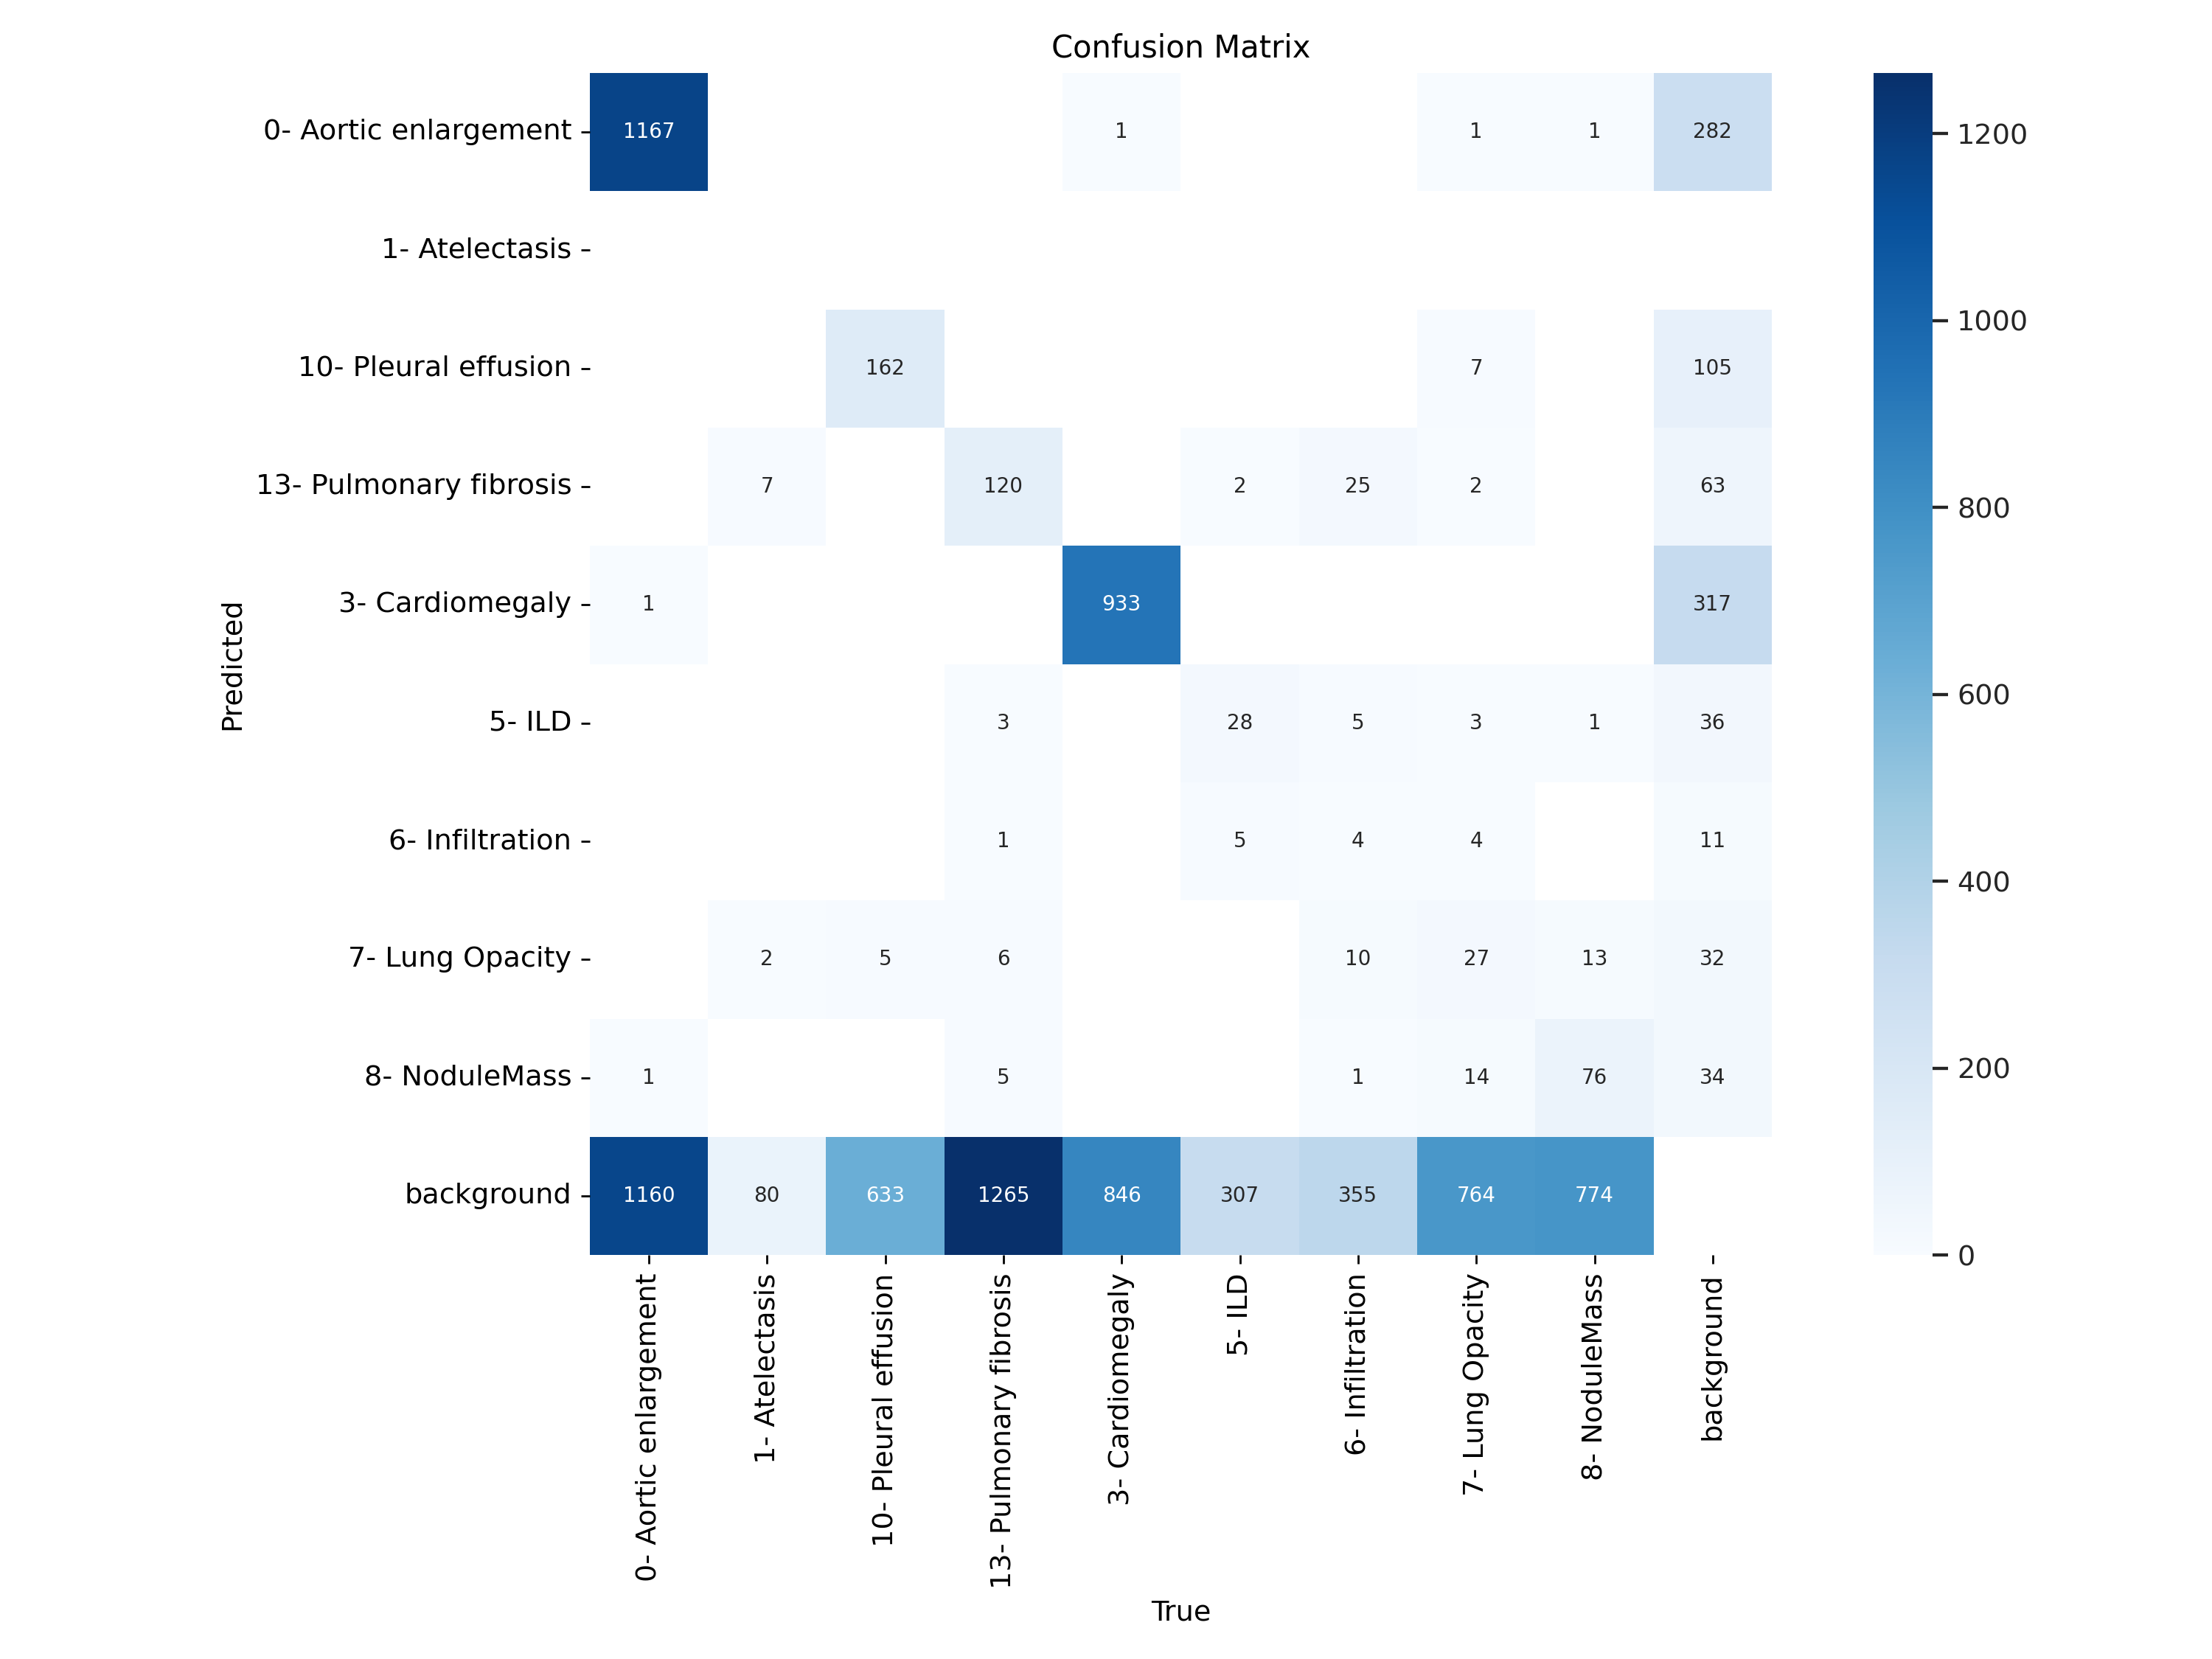

In [24]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

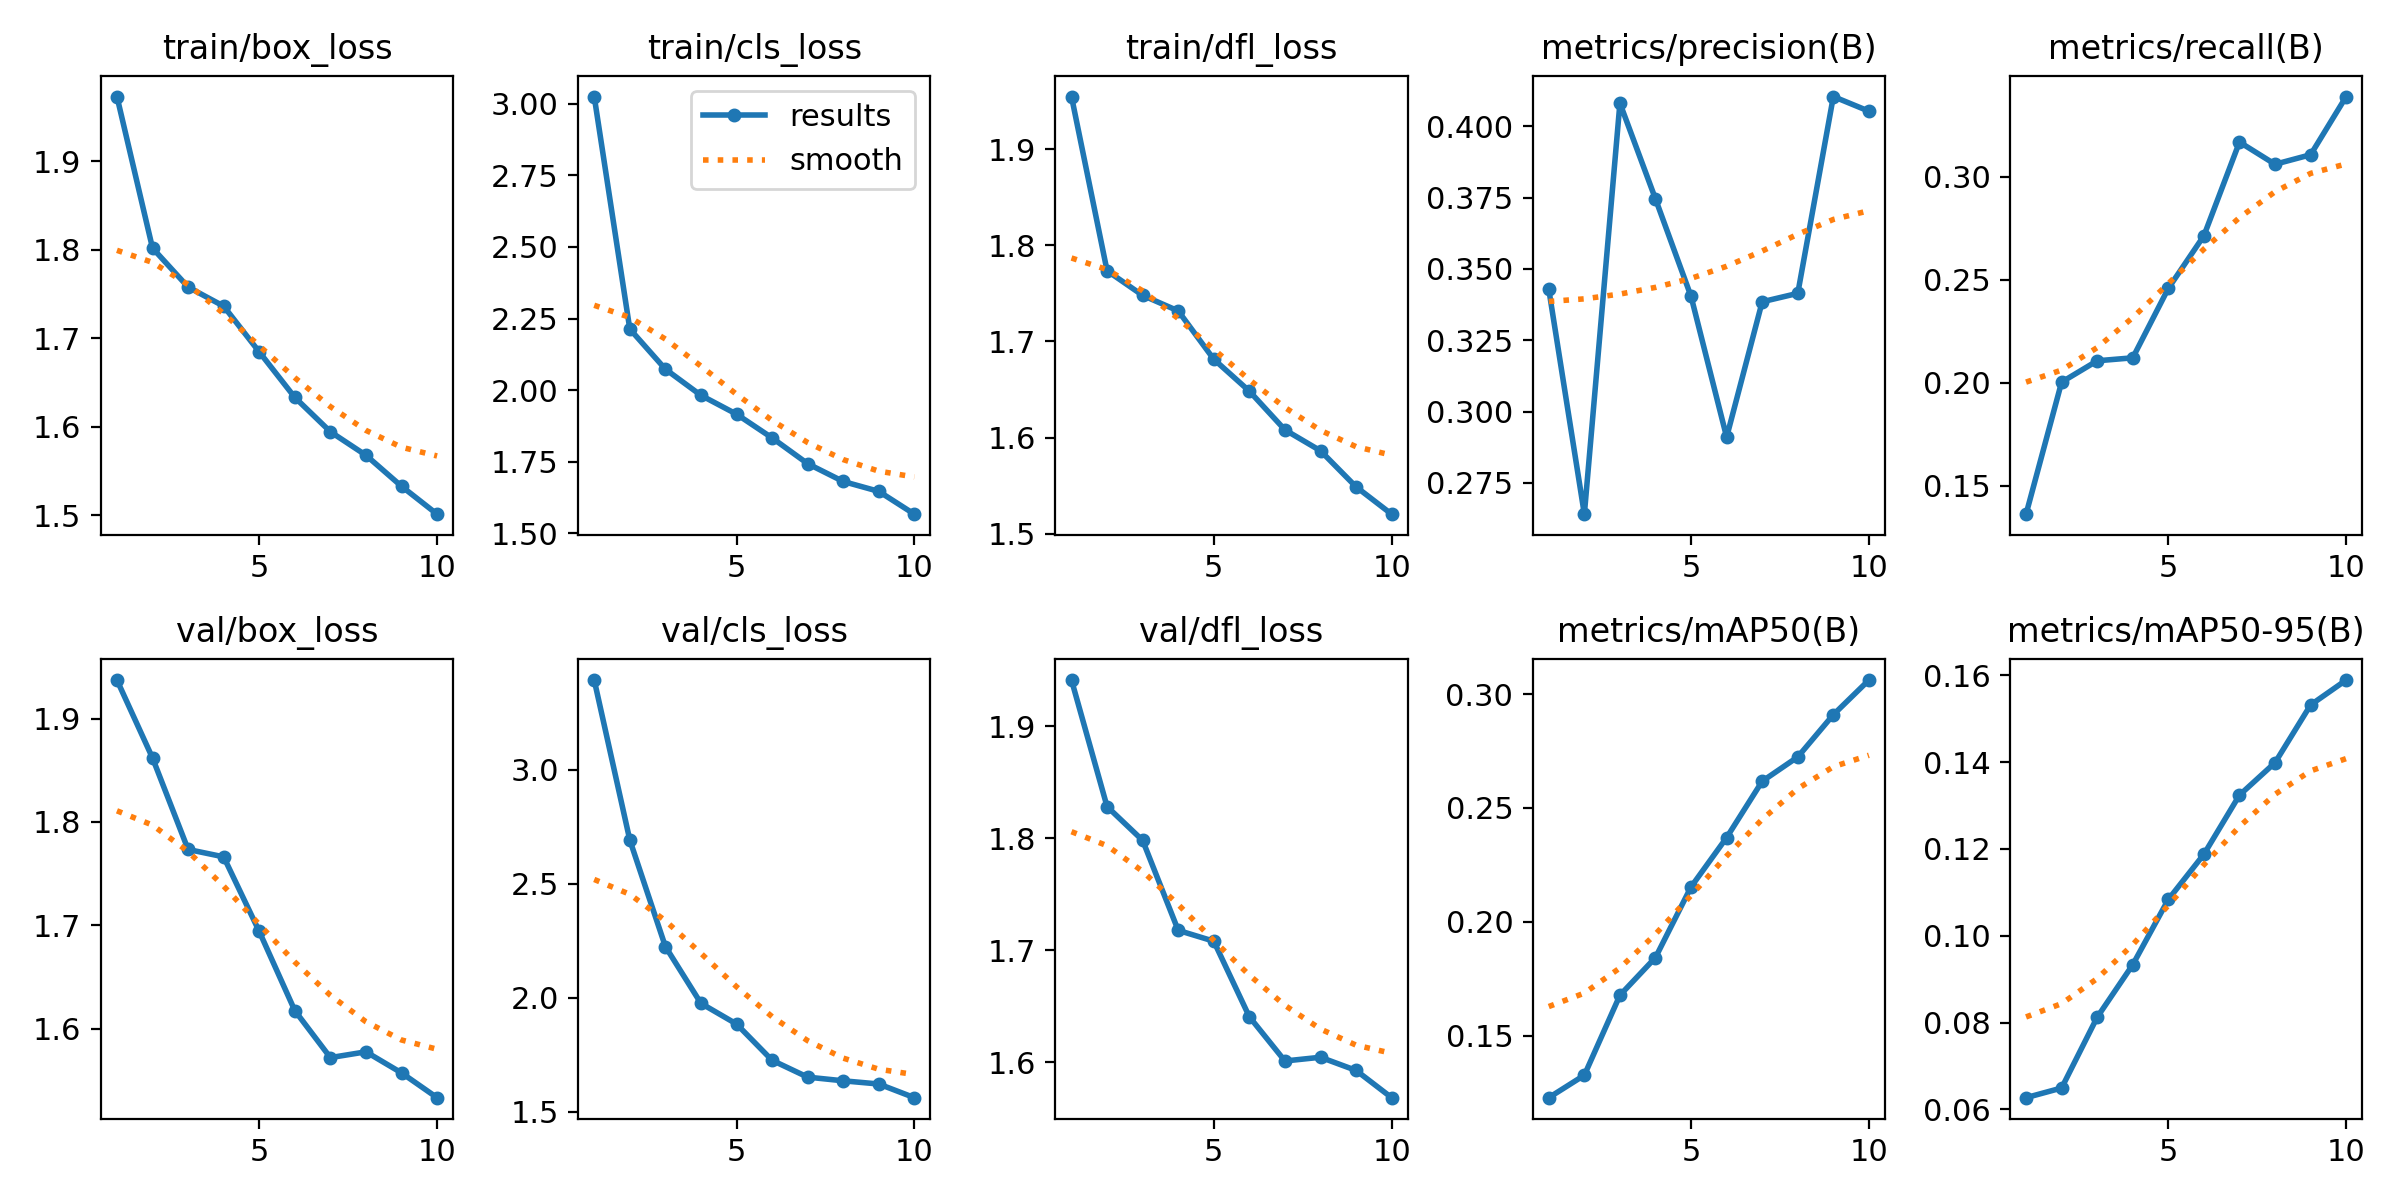

In [25]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

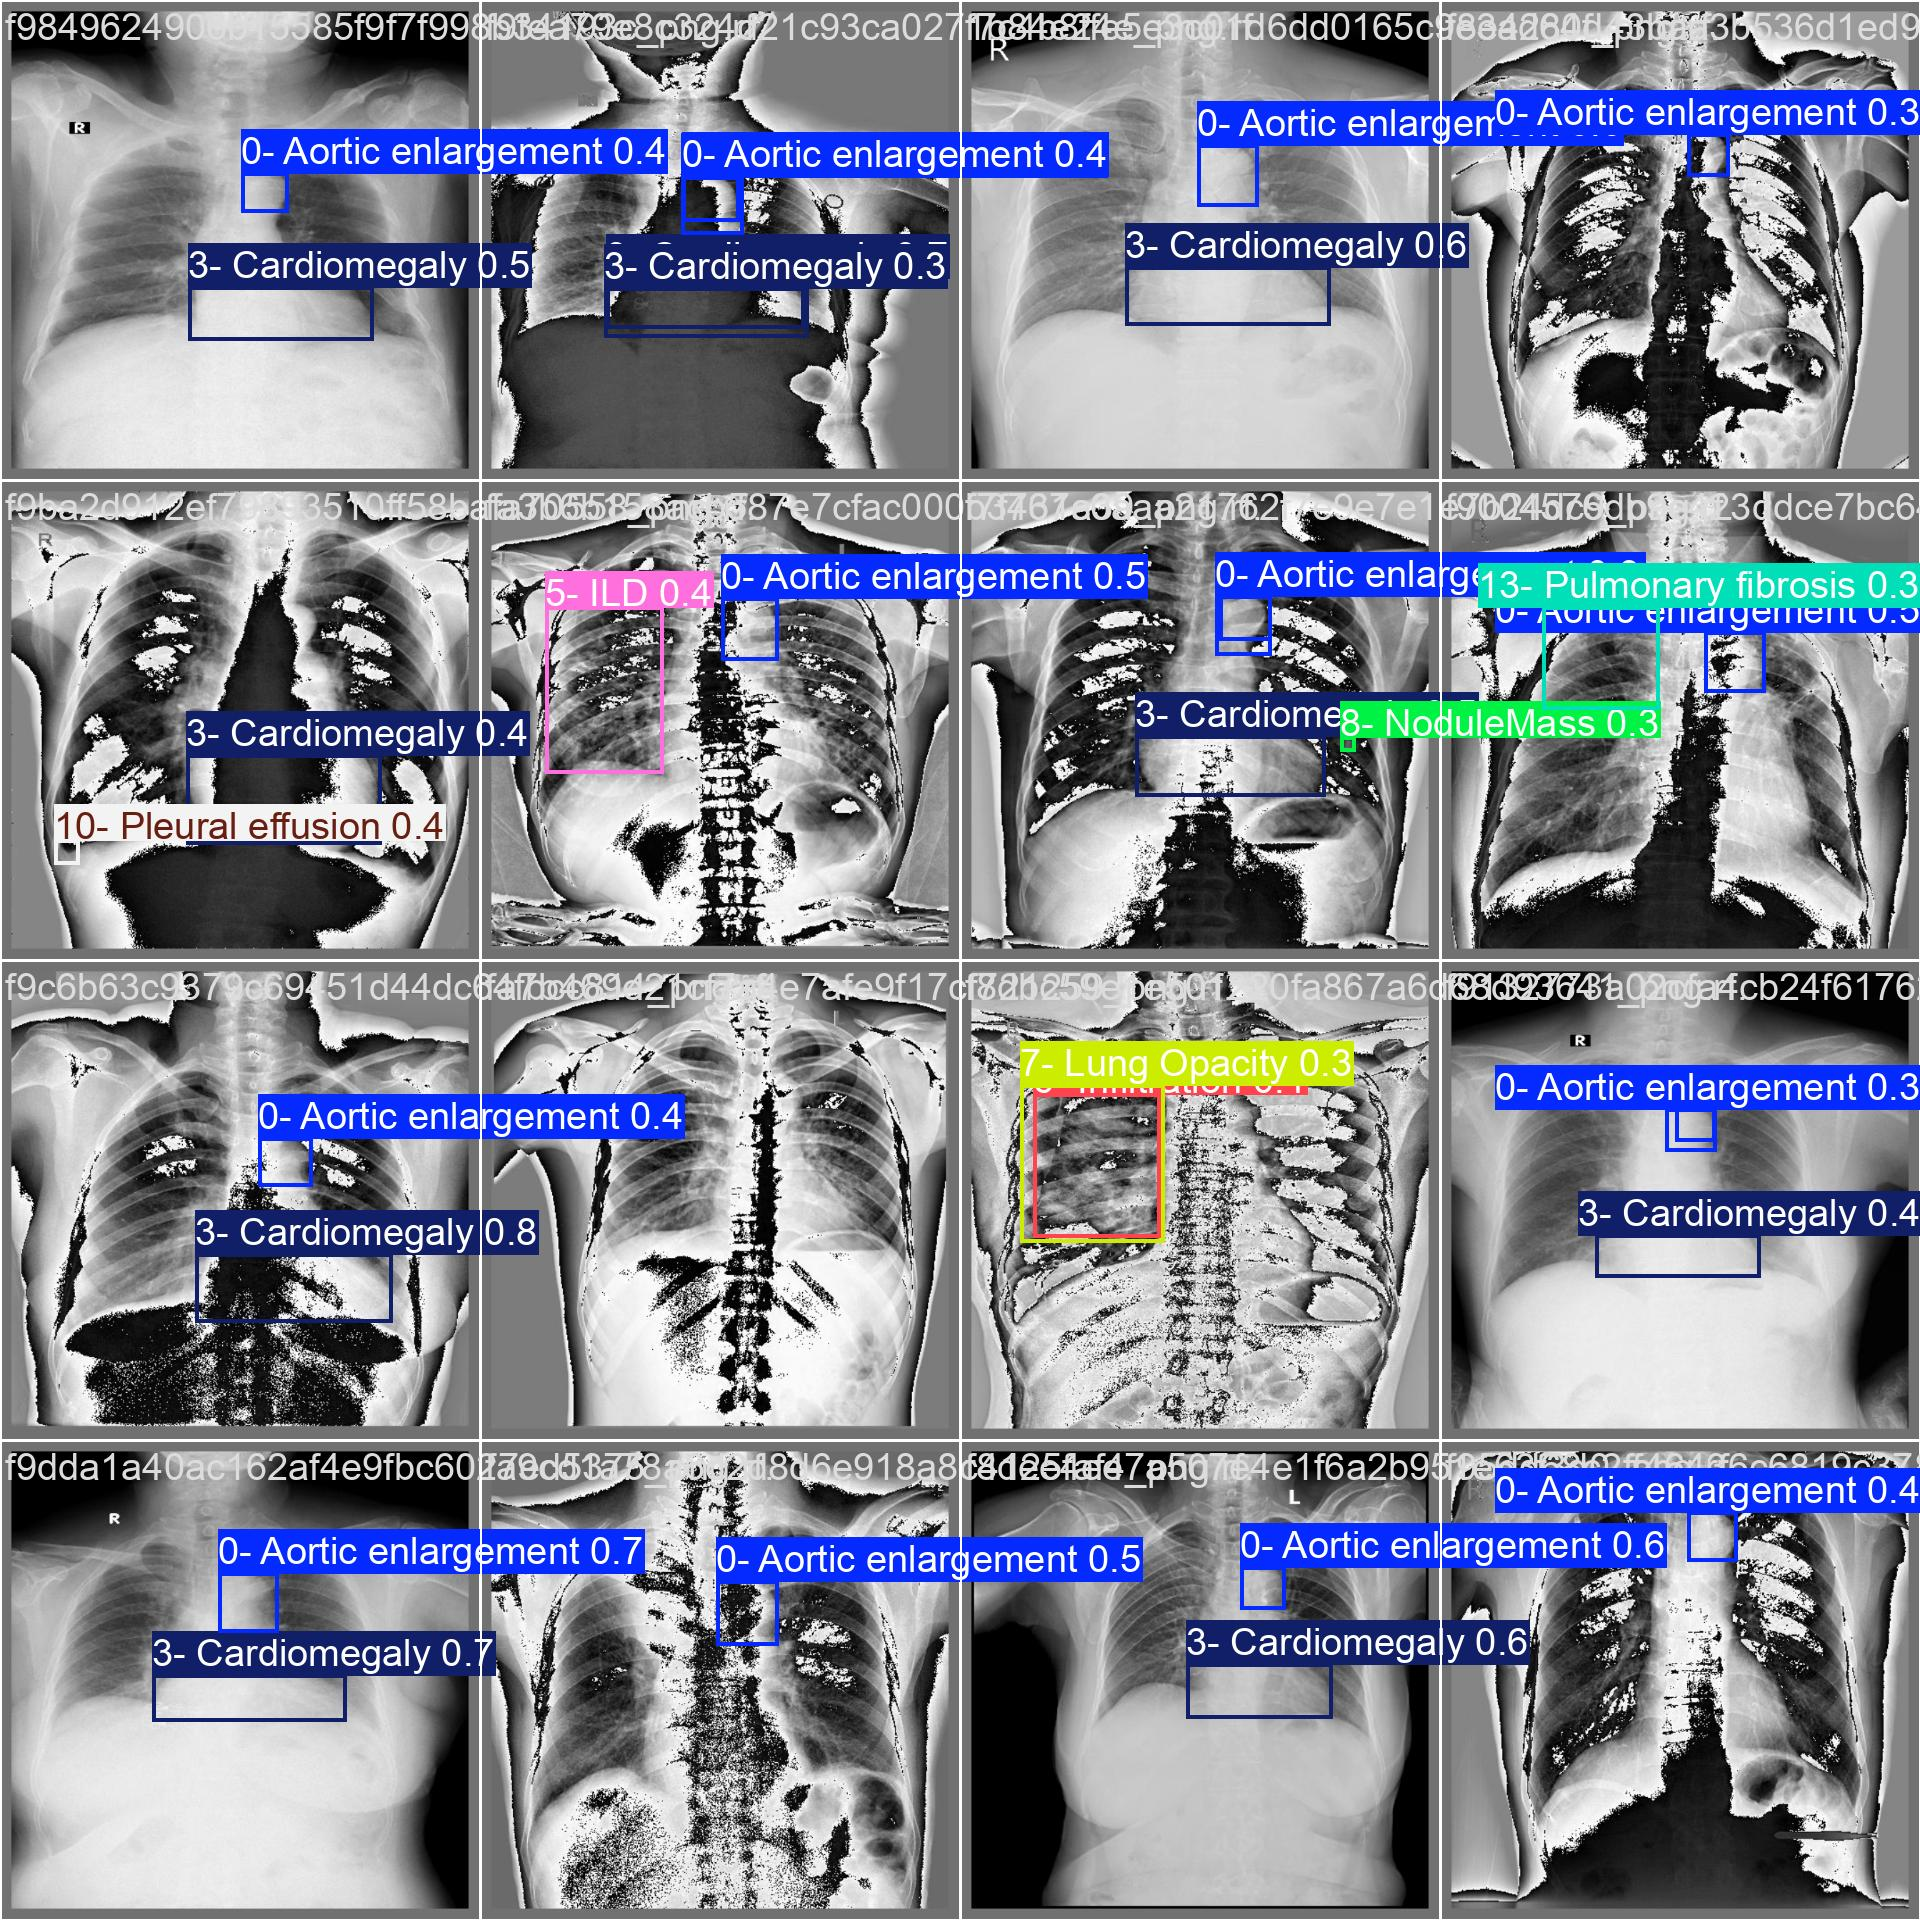

In [26]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [27]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,036,971 parameters, 0 gradients, 67.7 GFLOPs
val: Scanning /content/datasets/datasets/chest-xray-yolo-6/valid/labels.cache... 1405 images, 9 backgrounds, 0 corrupt: 100% 1405/1405 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 88/88 [00:40<00:00,  2.16it/s]
                   all       1405       8827      0.405      0.339      0.307      0.159
 0- Aortic enlargement        986       2329      0.683      0.632      0.697       0.42
        1- Atelectasis         54         89      0.368     0.0786     0.0837     0.0387
  10- Pleural effusion        327        800      0.282      0.492       0.33      0.125
13- Pulmonary fibrosis        496       1400      0.275      0.285      0.204     0.0743
       3- Cardiomegaly        760       1780      0.637      0.602      0.664      0.436
                5- IL

## Inference with custom model

In [28]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,036,971 parameters, 0 gradients, 67.7 GFLOPs

image 1/504 /content/datasets/datasets/chest-xray-yolo-6/test/images/009d837e29ba400e03856cf8d6a5b545_png.rf.baa817b0ccc36ccc41accf5e5f784804.jpg: 640x640 1 0- Aortic enlargement, 1 3- Cardiomegaly, 36.9ms
image 2/504 /content/datasets/datasets/chest-xray-yolo-6/test/images/01570ee44031e4ebab6031501293bf66_png.rf.3cbe1567df4ca1cccb9c8787a862fc32.jpg: 640x640 1 13- Pulmonary fibrosis, 3 3- Cardiomegalys, 36.9ms
image 3/504 /content/datasets/datasets/chest-xray-yolo-6/test/images/02222df826791117f315ecb2b58c5b69_png.rf.bdc8934a33271c8f37d5fa63ba5f34d6.jpg: 640x640 1 0- Aortic enlargement, 1 3- Cardiomegaly, 36.8ms
image 4/504 /content/datasets/datasets/chest-xray-yolo-6/test/images/02957c14fee52ac6d0617e6d86275a25_png.rf.238502ef1d92a136528363b545a3d05e.jpg: 640x640 1 0- Aortic enlargement, 1 3- Cardiomegaly, 36.9ms
image 

**NOTE:** Let's take a look at few results.

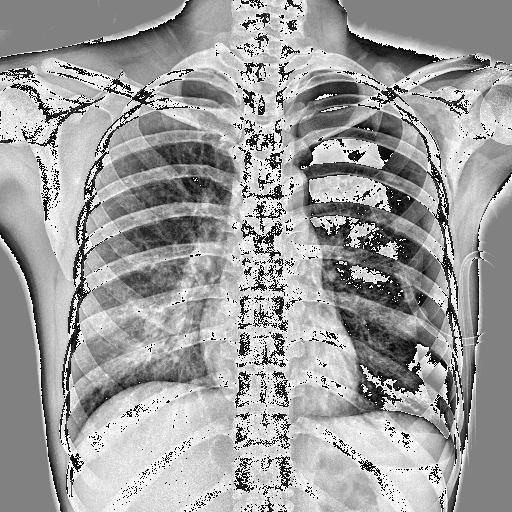

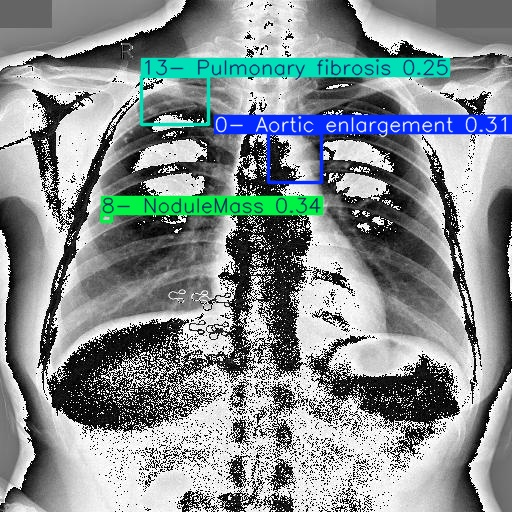

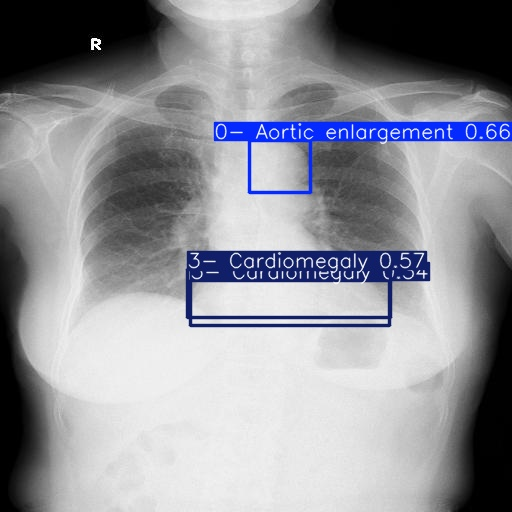

In [29]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")